## Начало работы с удаленным репозиторием

In [1]:
from google.colab import drive
import sys

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Создадим папку "/content/gdrive/My\ Drive/project_folder" и склонируем туда наш проект

In [6]:
!mkdir /content/gdrive/My\ Drive/project_folder
%cd /content/gdrive/My\ Drive/project_folder

/content/gdrive/My Drive/project_folder4


In [7]:
! git clone --recursive https://github.com/Malkovsky/distributed-learning.git

Cloning into 'distributed-learning'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 89 (delta 27), reused 65 (delta 14), pack-reused 0
Unpacking objects: 100% (89/89), done.
Submodule 'wide-resnet.pytorch' (https://github.com/meliketoy/wide-resnet.pytorch.git) registered for path 'wide_resnet_submodule'
Cloning into '/content/gdrive/My Drive/project_folder4/distributed-learning/wide_resnet_submodule'...
remote: Enumerating objects: 13, done.        
remote: Counting objects: 100% (13/13), done.        
remote: Compressing objects: 100% (10/10), done.        
remote: Total 124 (delta 4), reused 11 (delta 3), pack-reused 111        
Receiving objects: 100% (124/124), 674.93 KiB | 14.36 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Submodule path 'wide_resnet_submodule': checked out '292b3ede0651e349dd566f9c23408aa572f1bd92'


## Обучение модели

Настроим GPU: Edit -> Notebook settings -> [в предложенном списке выбрать GPU]

In [ ]:
# перед началом работы -- нужно монтировать гугл-диск
# drive.mount('/content/gdrive')

Добавим путь до репозитория в sys.path

In [8]:
sys.path.append('/content/gdrive/My Drive/project_folder/distributed-learning')

#### Обучение модели lenet на датасете cifar

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import wide_resnet_submodule.config as cf
from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode


import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

#### Настраиваем топологию сети

In [7]:
# Select simple topology
topology = {'Alice':   {'Alice': .9,   'Bob': 0.05, 'Charlie': 0.05},
         'Bob':     {'Alice': 0.05, 'Bob': .9,   'Charlie': 0.05},
         'Charlie': {'Alice': 0.05, 'Bob': 0.05, 'Charlie': .9}}
n_agents = len(topology)

#### Подготавливаем данные

In [8]:
def prepare_dataset(topology, n_agents, batch_size=cf.batch_size):
    dataset_name = 'cifar10'
    transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
      ]) # meanstd transformation

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                            train=True, download=True,
                                            transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                          train=False, download=False,
                                          transform=transform_test)
  
    sizes = [len(trainset) // n_agents for i in range(n_agents)]
    sizes[-1] += len(trainset) % n_agents
    subsets = torch.utils.data.random_split(trainset, sizes)
    train_loaders = {node_name: torch.utils.data.DataLoader(subset,
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      num_workers=2)
                for node_name, subset in zip(topology, subsets)
              }
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    return train_loaders, test_loader

In [9]:
train_loaders, test_loader = prepare_dataset(topology, n_agents)

Files already downloaded and verified


#### Настраиваем параметры

In [10]:
model_name = 'lenet'
num_classes = 10
model_args = [num_classes]
criterion = nn.CrossEntropyLoss
learning_rate = 0.02

optimizer = optim.SGD
optimizer_kwargs = {'momentum': 0.9, 'weight_decay': 5e-4}
num_epochs = 10
epoch_len = min(len(tl) for tl in train_loaders.values())

#### Инициализация модели и запуск обучения

In [11]:
# init master node
master = MasterNode(node_names=topology.keys(),
                    model=model_name, # lenet / vggnet / resnet / wide-resnet
                    model_args=model_args, # arguments for model(*model_args)
                    optimizer=optimizer, # SGD or smth like that
                    optimizer_kwargs=optimizer_kwargs, # arguments for optimizer(**optimizer_kwargs)
                    error=criterion, # loss function
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    train_loaders=train_loaders, # dict of train loaders, train_loaders[node_name] = train loader for node_name
                    test_loader=test_loader, # general test loader
                    stat_step=100, # save statistic each stat step 
                    epoch=num_epochs, # number of epochs
                    epoch_len=epoch_len, # length each epoch
                    epoch_cons_num=1 # the first epoch from which consensus begins
                   )

In [12]:
# init consensus nodes
master.initialize_nodes()

In [20]:
master.start_consensus()
print('Done!')

Epoch: 1, Step: 100, Node Alice: accuracy 10.98, loss 230.28
Epoch: 1, Step: 100, Node Bob: accuracy 10.31, loss 230.29
Epoch: 1, Step: 100, Node Charlie: accuracy 10.38, loss 230.28
Epoch: 2, Step: 200, Node Alice: accuracy 10.35, loss 230.23
Epoch: 2, Step: 200, Node Bob: accuracy 10.00, loss 230.27
Epoch: 2, Step: 200, Node Charlie: accuracy 10.06, loss 230.25
Epoch: 3, Step: 300, Node Alice: accuracy 10.57, loss 230.21
Epoch: 3, Step: 300, Node Bob: accuracy 10.33, loss 230.24
Epoch: 3, Step: 300, Node Charlie: accuracy 11.56, loss 230.22
Epoch: 4, Step: 400, Node Alice: accuracy 10.63, loss 230.19
Epoch: 4, Step: 400, Node Bob: accuracy 10.69, loss 230.22
Epoch: 4, Step: 400, Node Charlie: accuracy 10.70, loss 230.21
Epoch: 4, Step: 500, Node Alice: accuracy 14.08, loss 230.17
Epoch: 4, Step: 500, Node Bob: accuracy 13.50, loss 230.18
Epoch: 4, Step: 500, Node Charlie: accuracy 13.66, loss 230.17
Epoch: 5, Step: 600, Node Alice: accuracy 14.30, loss 230.12
Epoch: 5, Step: 600, Nod

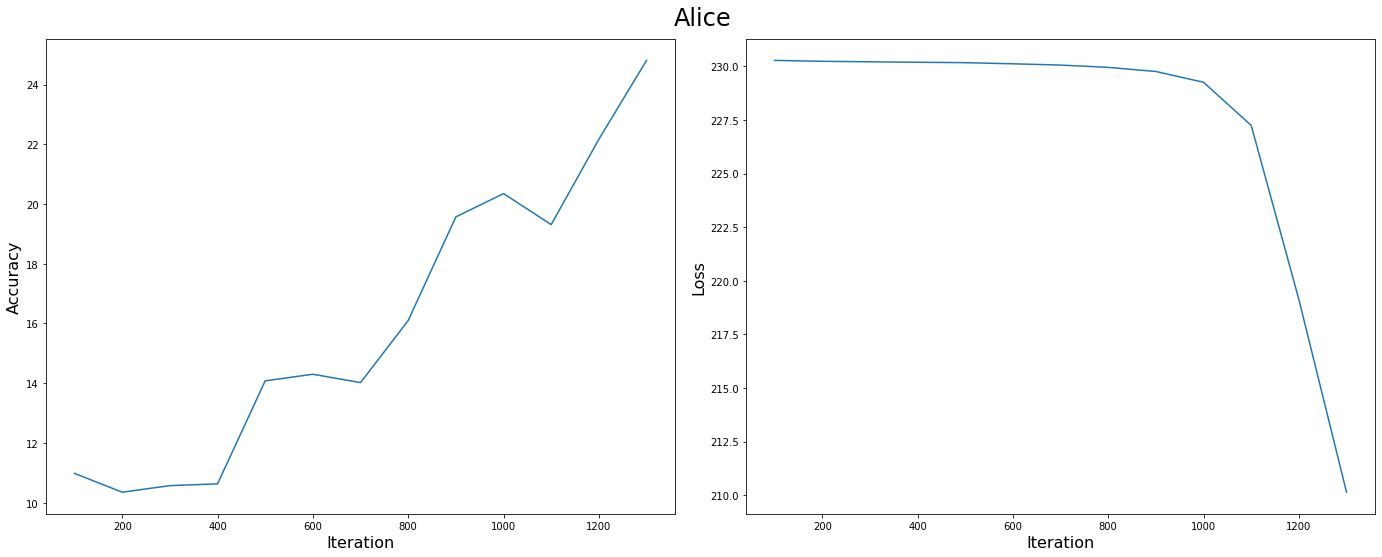

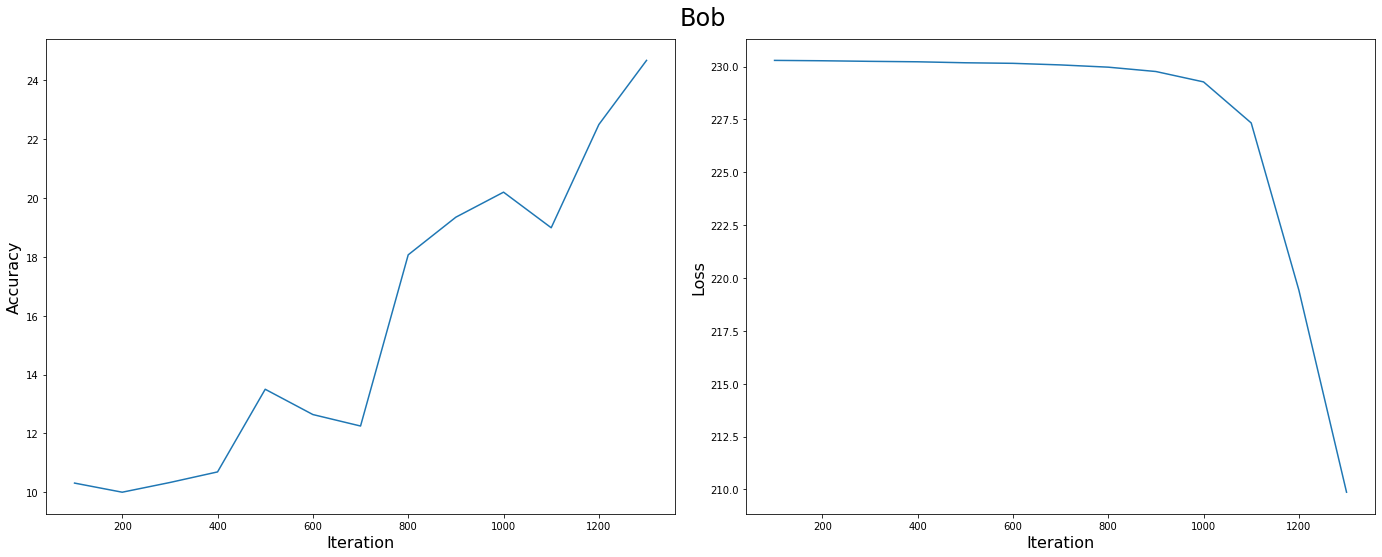

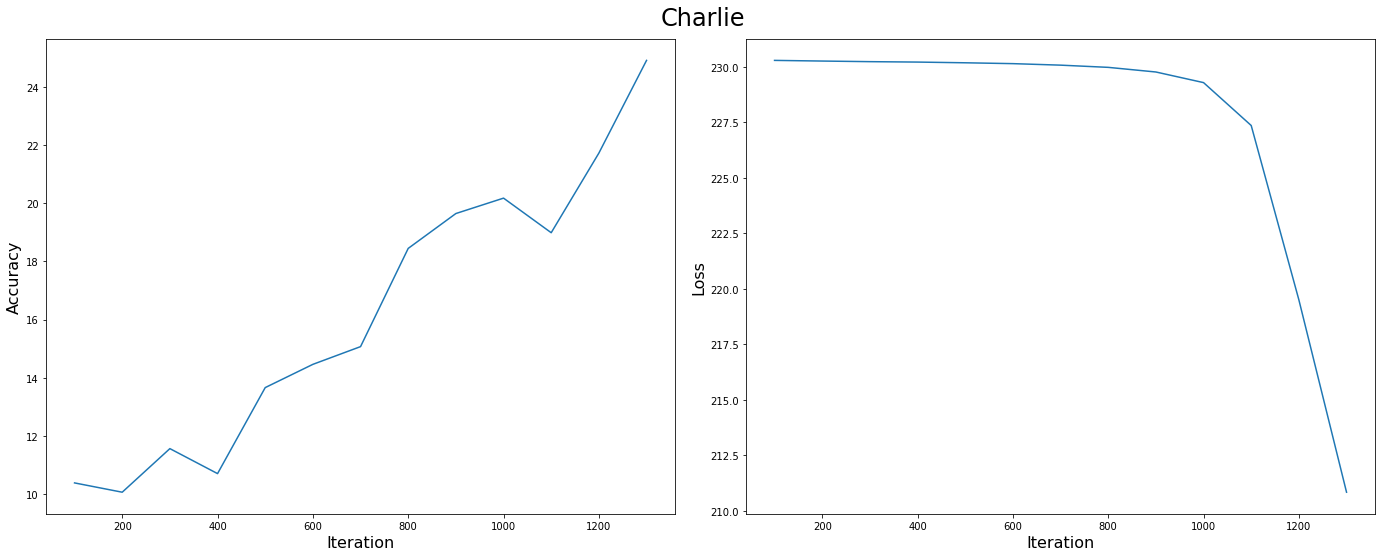

In [21]:
# Accuracy and loss plots for each node
for node in master.network.values():
    node.show_graphs()